In [1]:
import os
import sys
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from datetime import datetime
from pathlib import Path

from scipy.stats import pearsonr
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# set fonts configuration - Arial
matplotlib.rcParams['font.family'] = "Open Sans"
matplotlib.rcParams['font.sans-serif'] = "Arial"

# get normal font and store it in `fira_sans_regular`
personal_path = '/home/wmtsai/anaconda3/fonts/arial/'
font_path = personal_path + 'ARIAL.TTF'
arial_reg = FontProperties(fname=font_path)

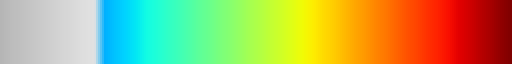

In [4]:
colors1 = plt.cm.Greys_r(np.linspace(0.6, 0.8, 10))
colors2 = plt.cm.jet(np.linspace(0.3, 1, 40))

# combine them and build a new colormap
colors = np.vstack((colors1, colors2))
mixedmap = LinearSegmentedColormap.from_list('my_colormap', colors)
mixedmap

In [6]:
# get mcsstats 
mcsstats_dir = Path('/scratch/wmtsai/temp_mcs/mcs_stats/mcs_tracks_non2mcs/')

year_list = np.arange(2001,2021)

bins_mcsduration = np.arange(5,300)
bins_m2eduration = np.arange(0,61)

samples_mcs_duration = np.zeros((2,len(bins_mcsduration)-1))
samples_m2e_duration = np.zeros((2,len(bins_m2eduration)-1))

for n, year in enumerate(year_list):
    
    data_stats = xr.open_dataset(mcsstats_dir / 'mcs_tracks_non2mcs_{}.tropics30NS.extend.nc'.format(year))
    mcs_duration = data_stats.mcs_duration
    m2e_duration = data_stats.idt_mcs_end - data_stats.idt_mcs_mature
    
    idt_mcs_mature = data_stats.idt_mcs_mature
    lsflag = data_stats.landsea_flag.isel(times=idt_mcs_mature)
    idx_land = np.where(lsflag == 1)[0]
    idx_ocean = np.where(lsflag == 0)[0]
    
    for n, (mcs_d, m2e_d, idx_surface) in enumerate(zip([mcs_duration, mcs_duration],
                                                        [m2e_duration, m2e_duration],
                                                        [idx_land, idx_ocean])): # n: land, sea
        
        mcs_duration = mcs_d.isel(tracks=idx_surface)
        m2e_duration = m2e_d.isel(tracks=idx_surface)
        
        (samples_mcs, bins_mcs) = np.histogram(mcs_duration, bins=bins_mcsduration)
        (samples_m2e, bins_m2e) = np.histogram(m2e_duration, bins=bins_m2eduration)
        
        samples_mcs_duration[n,:] += samples_mcs
        samples_m2e_duration[n,:] += samples_m2e

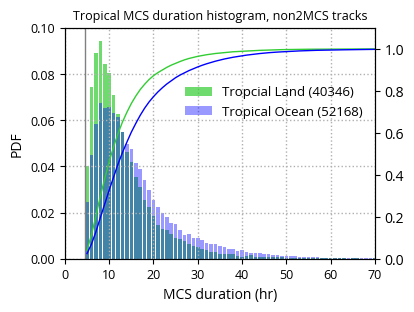

In [9]:
fig, ax = plt.subplots(1,1,figsize=(4,3))

# over land and ocean
pdf_land = samples_mcs_duration[0,:]/samples_mcs_duration[0,:].sum()
pdf_ocean = samples_mcs_duration[1,:]/samples_mcs_duration[1,:].sum()

ax.bar(bins_mcs[:-1], pdf_land, 
      alpha=0.7, color='limegreen', label='Tropcial Land ({})'.format(int(samples_mcs_duration[0,:].sum())))
# over ocean
ax.bar(bins_mcs[:-1], pdf_ocean,
      alpha=0.4, color='b', label='Tropical Ocean ({})'.format(int(samples_mcs_duration[1,:].sum())))
ax.vlines(x=4.5,ymin=0,ymax=0.1,lw=1,color='grey')

ax2 = ax.twinx()
ax2.plot(bins_mcs[:-1], np.cumsum(pdf_land), color='limegreen', lw=1)
ax2.plot(bins_mcs[:-1], np.cumsum(pdf_ocean), color='b', lw=1)

ax.set_xlim([0,70])
ax.set_ylim([0,0.1])
ax2.set_ylim([0,1.1])
ax.set_ylabel('PDF', fontsize=10)
ax.set_xlabel('MCS duration (hr)', fontsize=10)
ax.tick_params(labelsize=9)
ax.grid(lw=1, ls=':')
ax.legend(frameon=False, fontsize=9.5, bbox_to_anchor=(0.5,0.3,0.5,0.5))
ax.set_title('Tropical MCS duration histogram, non2MCS tracks', fontsize=9)

fig.savefig('/scratch/wmtsai/temp_mcs/fig/MCSduration_histgram.pdf',
            bbox_inches='tight', transparent=False)

plt.show()

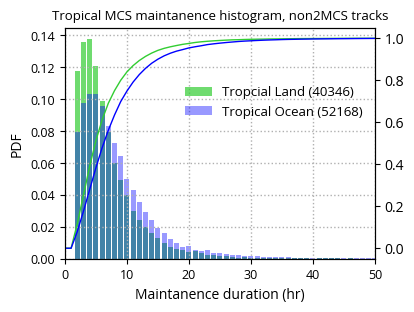

In [8]:
fig, ax = plt.subplots(1,1,figsize=(4,3))

# over land and ocean
pdf_land = samples_m2e_duration[0,:]/samples_m2e_duration[0,:].sum()
pdf_ocean = samples_m2e_duration[1,:]/samples_m2e_duration[1,:].sum()

ax.bar(bins_m2e[:-1], pdf_land, 
      alpha=0.7, color='limegreen', label='Tropcial Land ({})'.format(int(samples_mcs_duration[0,:].sum())))
# over ocean
ax.bar(bins_m2e[:-1], pdf_ocean,
      alpha=0.4, color='b', label='Tropical Ocean ({})'.format(int(samples_mcs_duration[1,:].sum())))

ax2 = ax.twinx()
ax2.plot(bins_m2e[:-1], np.cumsum(pdf_land), color='limegreen', lw=1)
ax2.plot(bins_m2e[:-1], np.cumsum(pdf_ocean), color='b', lw=1)

ax.set_xlim([0,50])
ax.set_ylabel('PDF', fontsize=10)
ax.set_xlabel('Maintanence duration (hr)', fontsize=10)
ax.tick_params(labelsize=9)
ax.grid(lw=1, ls=':')
ax.legend(frameon=False, fontsize=9.5, bbox_to_anchor=(0.5,0.3,0.5,0.5))
ax.set_title('Tropical MCS maintanence histogram, non2MCS tracks', fontsize=9.5)
plt.show()

# fig.savefig('/scratch/wmtsai/temp_mcs/fig/MCSduration_histgram.png',
#            dpi=300, bbox_inches='tight', transparent=False)

#### MCS stats as a function of MCS duration
- stats and distribution conditioned on the MCS duration

In [ ]:
%%time
# propagation distributions
# generate dataset [duration, distance]
year_list = np.arange(2001,2021)

for n, year in enumerate(year_list):
    print('processing year: {}'.format(year))
    dir_mcs_track = Path('/scratch/wmtsai/temp_mcs/mcs_stats/mcs_tracks_non2mcs')
    data_track = xr.open_dataset(dir_mcs_track / 'mcs_tracks_non2mcs_{}.tropics30NS.extend.nc'.format(year))

    #### calculate MCS propagation (position diff. between the MCS init. and end phase) ###
    mcs_propagate = []
    for track in data_track.tracks.values:

        data_track_sub = data_track.sel(tracks=track)
        idt_phase = [data_track_sub.idt_mcs_init, data_track_sub.idt_mcs_end]

        lon_traject = []
        lat_traject = []
        position_arrow = []
        for idt in idt_phase: # initial and ending phase 

            meanlon = data_track_sub.isel(times=idt).meanlon
            meanlat = data_track_sub.isel(times=idt).meanlat
            lon_traject.extend([meanlon])
            lat_traject.extend([meanlat])
            
        # calculate the propagating distance (km), 1-deg. ~ 100 km 
        dist_traject = 100*np.sqrt(np.abs(lon_traject[1]-lon_traject[0])**2 + 
                               np.abs(lat_traject[1]-lat_traject[0])**2)
        
        mcs_propagate.append(dist_traject)
    ######## end calc. ########    
          
    # fill into 2-D histograms
    bins_duration = np.arange(5,73,1)
    bins_propagate = np.arange(0,2000,25)

    (samples, bins_d, bins_propagate) = np.histogram2d(data_track.mcs_duration, mcs_propagate, bins=(bins_duration, bins_propagate))
    
    if n == 0:
        samples2d_all = samples
    else:
        samples2d_all += samples

In [ ]:
marg_pdf = np.zeros((len(bins_d)-1, len(bins_p)-1))
mean_cond = np.zeros(len(bins_d)-1)*np.nan
val_75th = np.copy(mean_cond)
val_25th = np.copy(mean_cond)

for i in range(len(bins_d)-1):
    pdf = samples2d_all[i,:]/np.sum(samples2d_all[i,:])
    marg_pdf[i,:] = pdf
    mean_cond[i] = np.sum((bins_p[:-1]+1/2*(bins_p[1]-bins_p[0]))*pdf)
    cdf = np.cumsum(pdf) # cdf
    val_75th[i] = bins_propagate[np.argmin(abs(cdf - 0.9))]
    val_25th[i] = bins_propagate[np.argmin(abs(cdf - 0.1))]

fig, ax = plt.subplots(1,1,figsize=(5,3.5))
cp = ax.pcolormesh(bins_d[:-1], bins_propagate[:-1], marg_pdf.T, cmap=mixedmap,
                   vmin=0.0001, vmax=0.1)
cp.cmap.set_under('w')
cbar = plt.colorbar(cp,ax=ax,shrink=0.7,pad=0.01)
cbar.set_label('number',fontsize=10)

# adding mean and percentiles
ax.plot(bins_d[:-1]+1/2*(bins_d[1]-bins_d[0]), mean_cond, '-m', lw=1)
ax.plot(bins_d[:-1]+1/2*(bins_d[1]-bins_d[0]), val_75th, '--m', lw=1)
ax.plot(bins_d[:-1]+1/2*(bins_d[1]-bins_d[0]), val_25th, '--m', lw=1)

ax.set_xlabel('MCS duration (hr)',fontsize=10)
ax.set_ylabel('MCS propagation (Init.-End) (km)',fontsize=10)
ax.set_xticks(np.arange(5,75,5));
ax.set_xlim([5,30])

ax.tick_params(labelsize=9)

In [ ]:
%%time
# total rainrate at the mature
year_list = np.arange(2001,2021)

for n, year in enumerate(year_list):
    #print('processing year: {}'.format(year))
    dir_mcs_track = Path('/scratch/wmtsai/temp_mcs/mcs_stats/mcs_tracks_non2mcs')
    data_track = xr.open_dataset(dir_mcs_track / 'mcs_tracks_non2mcs_{}.tropics30NS.extend.nc'.format(year))
    
    idt_mcs_mature = data_track.idt_mcs_mature
    totrain = data_track.sel(times=idt_mcs_mature).total_rain
    area = data_track.sel(times=idt_mcs_mature).area/(100) # pixel number 
    mean_precip = totrain/area
    
    # fill into 2-D histograms
    bins_duration = np.arange(5,73,1)
    bins_rainrate = np.arange(0,20,0.25)

    (samples, bins_d, bins_rainrate) = np.histogram2d(data_track.mcs_duration, mean_precip, bins=(bins_duration, bins_rainrate))
    
    if n == 0:
        samples2d_totrain = samples
    else:
        samples2d_totrain += samples

In [ ]:
marg_pdf = np.zeros((len(bins_d)-1, len(bins_rainrate)-1))
mean_cond = np.zeros(len(bins_d)-1)*np.nan
val_75th = np.copy(mean_cond)
val_25th = np.copy(mean_cond)

for i in range(len(bins_d)-1):
    pdf = samples2d_totrain[i,:]/np.sum(samples2d_totrain[i,:])
    marg_pdf[i,:] = pdf
    mean_cond[i] = np.sum((bins_rainrate[:-1]+1/2*(bins_rainrate[1]-bins_rainrate[0]))*pdf)
    cdf = np.cumsum(pdf) # cdf
    val_75th[i] = bins_rainrate[np.argmin(abs(cdf - 0.9))]
    val_25th[i] = bins_rainrate[np.argmin(abs(cdf - 0.1))]

fig, ax = plt.subplots(1,1,figsize=(5,3.5))
cp = ax.pcolormesh(bins_d[:-1], bins_rainrate[:-1], marg_pdf.T, cmap=mixedmap,
                   vmin=0.0001, vmax=0.1)
cp.cmap.set_under('w')
cbar = plt.colorbar(cp,ax=ax,shrink=0.7,pad=0.01)
cbar.set_label('PDF |$_{duration}$',fontsize=10)

# adding mean and percentiles
ax.plot(bins_d[:-1]+1/2*(bins_d[1]-bins_d[0]), mean_cond, '-m', lw=1)
ax.plot(bins_d[:-1]+1/2*(bins_d[1]-bins_d[0]), val_75th, '--m', lw=1)
ax.plot(bins_d[:-1]+1/2*(bins_d[1]-bins_d[0]), val_25th, '--m', lw=1)

ax.set_xlabel('MCS duration (hr)',fontsize=10)
ax.set_ylabel('MCS mean precip. at Mature (mm/hr)',fontsize=10)
ax.set_xticks(np.arange(5,75,5));
ax.set_xlim([5,30])

ax.tick_params(labelsize=9)

In [ ]:
%%time
# heavy rainrate (>10mm/hr) at the mature
year_list = np.arange(2001,2021)

for n, year in enumerate(year_list):
    #print('processing year: {}'.format(year))
    dir_mcs_track = Path('/scratch/wmtsai/temp_mcs/mcs_stats/mcs_tracks_non2mcs')
    data_track = xr.open_dataset(dir_mcs_track / 'mcs_tracks_non2mcs_{}.tropics30NS.extend.nc'.format(year))
    
    idt_mcs_mature = data_track.idt_mcs_mature
    rainrate_heavyrain = data_track.sel(times=idt_mcs_mature).rainrate_heavyrain
    
    # fill into 2-D histograms
    bins_duration = np.arange(5,73,1)
    bins_rainrate = np.arange(10,40,0.5)

    (samples, bins_d, bins_rainrate) = np.histogram2d(data_track.mcs_duration, rainrate_heavyrain, bins=(bins_duration, bins_rainrate))
    
    if n == 0:
        samples2d_rainrate_heavyrain = samples
    else:
        samples2d_rainrate_heavyrain += samples

In [ ]:
marg_pdf = np.zeros((len(bins_d)-1, len(bins_rainrate)-1))
mean_cond = np.zeros(len(bins_d)-1)*np.nan
val_75th = np.copy(mean_cond)
val_25th = np.copy(mean_cond)

for i in range(len(bins_d)-1):
    pdf = samples2d_rainrate_heavyrain[i,:]/np.sum(samples2d_rainrate_heavyrain[i,:])
    marg_pdf[i,:] = pdf
    mean_cond[i] = np.sum((bins_rainrate[:-1]+1/2*(bins_rainrate[1]-bins_rainrate[0]))*pdf)
    cdf = np.cumsum(pdf) # cdf
    val_75th[i] = bins_rainrate[np.argmin(abs(cdf - 0.9))]
    val_25th[i] = bins_rainrate[np.argmin(abs(cdf - 0.1))]

fig, ax = plt.subplots(1,1,figsize=(5,3.5))
cp = ax.pcolormesh(bins_d[:-1], bins_rainrate[:-1], marg_pdf.T, cmap=mixedmap,
                   vmin=0.0001, vmax=0.1)
cp.cmap.set_under('w')
cbar = plt.colorbar(cp,ax=ax,shrink=0.7,pad=0.01)
cbar.set_label('PDF |$_{duration}$',fontsize=10)

# adding mean and percentiles
ax.plot(bins_d[:-1]+1/2*(bins_d[1]-bins_d[0]), mean_cond, '-m', lw=1)
ax.plot(bins_d[:-1]+1/2*(bins_d[1]-bins_d[0]), val_75th, '--m', lw=1)
ax.plot(bins_d[:-1]+1/2*(bins_d[1]-bins_d[0]), val_25th, '--m', lw=1)

ax.set_xlabel('MCS duration (hr)',fontsize=10)
ax.set_ylabel('MCS rainrate_heavyrain at Mature (mm/hr)',fontsize=10)
ax.set_xticks(np.arange(5,75,5));
ax.set_xlim([5,30])

ax.tick_params(labelsize=9)

In [ ]:
%%time
# heavy rainrate (>10mm/hr) at the mature
year_list = np.arange(2001,2021)

for n, year in enumerate(year_list):
    #print('processing year: {}'.format(year))
    dir_mcs_track = Path('/scratch/wmtsai/temp_mcs/mcs_stats/mcs_tracks_non2mcs')
    data_track = xr.open_dataset(dir_mcs_track / 'mcs_tracks_non2mcs_{}.tropics30NS.extend.nc'.format(year))
    
    idt_mcs_mature = data_track.idt_mcs_mature
    pf_npf = data_track.sel(times=idt_mcs_mature).pf_npf # number of precip features
    
    # fill into 2-D histograms
    bins_duration = np.arange(5,73,1)
    bins_npf = np.arange(0,40,1)

    (samples, bins_d, bins_npf) = np.histogram2d(data_track.mcs_duration, pf_npf
                                                      , bins=(bins_duration, bins_npf))
    
    if n == 0:
        samples2d_npf = samples
    else:
        samples2d_npf += samples

In [ ]:
marg_pdf = np.zeros((len(bins_d)-1, len(bins_npf)-1))
mean_cond = np.zeros(len(bins_d)-1)*np.nan
val_75th = np.copy(mean_cond)
val_25th = np.copy(mean_cond)

for i in range(len(bins_d)-1):
    pdf = samples2d_npf[i,:]/np.sum(samples2d_npf[i,:])
    marg_pdf[i,:] = pdf
    mean_cond[i] = np.sum((bins_npf[:-1]+1/2*(bins_npf[1]-bins_npf[0]))*pdf)
    cdf = np.cumsum(pdf) # cdf
    val_75th[i] = bins_npf[np.argmin(abs(cdf - 0.9))]
    val_25th[i] = bins_npf[np.argmin(abs(cdf - 0.1))]

fig, ax = plt.subplots(1,1,figsize=(5,3.5))
cp = ax.pcolormesh(bins_d[:-1], bins_npf[:-1], marg_pdf.T, cmap=mixedmap,
                   vmin=0.0001, vmax=0.1)
cp.cmap.set_under('w')
cbar = plt.colorbar(cp,ax=ax,shrink=0.7,pad=0.01)
cbar.set_label('PDF |$_{duration}$',fontsize=10)

# adding mean and percentiles
ax.plot(bins_d[:-1]+1/2*(bins_d[1]-bins_d[0]), mean_cond, '-m', lw=1)
ax.plot(bins_d[:-1]+1/2*(bins_d[1]-bins_d[0]), val_75th, '--m', lw=1)
ax.plot(bins_d[:-1]+1/2*(bins_d[1]-bins_d[0]), val_25th, '--m', lw=1)

ax.set_xlabel('MCS duration (hr)',fontsize=10)
ax.set_ylabel('MCS NPF at Mature (#)',fontsize=10)
ax.set_xticks(np.arange(5,75,5));
ax.set_xlim([5,30])

ax.tick_params(labelsize=9)

In [ ]:
%%time
# heavy rainrate (>10mm/hr) at the mature
year_list = np.arange(2001,2021)

for n, year in enumerate(year_list):
    #print('processing year: {}'.format(year))
    dir_mcs_track = Path('/scratch/wmtsai/temp_mcs/mcs_stats/mcs_tracks_non2mcs')
    data_track = xr.open_dataset(dir_mcs_track / 'mcs_tracks_non2mcs_{}.tropics30NS.extend.nc'.format(year))
    idt_mcs_init = data_track.idt_mcs_init
    ls_flag = data_track.landsea_flag.sel(times=idt_mcs_init)
    idx_ocean = np.where(ls_flag == 0)[0]
    
    idt_mcs_mature = data_track.idt_mcs_mature
    ccs_area = np.sqrt(data_track.sel(times=idt_mcs_mature).ccs_area) # km2
    
    # select subset
    mcs_duration = data_track.isel(tracks=idx_ocean).mcs_duration
    ccs_area = ccs_area.isel(tracks=idx_ocean)
    
    # fill into 2-D histograms
    bins_duration = np.arange(5,73,1)
    bins_ccsarea = np.arange(200,600,10)

    (samples, bins_d, bins_ccsarea) = np.histogram2d(mcs_duration, ccs_area
                                                      , bins=(bins_duration, bins_ccsarea))
    
    if n == 0:
        samples2d_ccsarea = samples
    else:
        samples2d_ccsarea += samples

In [ ]:
marg_pdf = np.zeros((len(bins_d)-1, len(bins_ccsarea)-1))
mean_cond = np.zeros(len(bins_d)-1)*np.nan
val_75th = np.copy(mean_cond)
val_25th = np.copy(mean_cond)

for i in range(len(bins_d)-1):
    pdf = samples2d_ccsarea[i,:]/np.sum(samples2d_ccsarea[i,:])
    marg_pdf[i,:] = pdf
    mean_cond[i] = np.sum((bins_ccsarea[:-1]+1/2*(bins_ccsarea[1]-bins_ccsarea[0]))*pdf)
    cdf = np.cumsum(pdf) # cdf
    val_75th[i] = bins_ccsarea[np.argmin(abs(cdf - 0.9))]
    val_25th[i] = bins_ccsarea[np.argmin(abs(cdf - 0.1))]

fig, ax = plt.subplots(1,1,figsize=(5,3.5))
cp = ax.pcolormesh(bins_d[:-1], bins_ccsarea[:-1], marg_pdf.T, cmap=mixedmap,
                   vmin=0.0001, vmax=0.1)
cp.cmap.set_under('w')
cbar = plt.colorbar(cp,ax=ax,shrink=0.7,pad=0.01)
cbar.set_label('PDF |$_{duration}$',fontsize=10)

# adding mean and percentiles
ax.plot(bins_d[:-1]+1/2*(bins_d[1]-bins_d[0]), mean_cond, '-m', lw=1)
ax.plot(bins_d[:-1]+1/2*(bins_d[1]-bins_d[0]), val_75th, '--m', lw=1)
ax.plot(bins_d[:-1]+1/2*(bins_d[1]-bins_d[0]), val_25th, '--m', lw=1)

ax.set_xlabel('MCS duration (hr)',fontsize=10)
ax.set_ylabel('MCS CCS area scale (km)',fontsize=10)
ax.set_xticks(np.arange(5,75,5))

ax.set_xlim([5,30])
ax.tick_params(labelsize=9)
ax.set_title('MCS CCS are at the mature phase, Ocean',fontsize=10);

In [ ]:
%%time
# heavy rainrate (>10mm/hr) at the mature
year_list = np.arange(2001,2021)

for n, year in enumerate(year_list):
    #print('processing year: {}'.format(year))
    dir_mcs_track = Path('/scratch/wmtsai/temp_mcs/mcs_stats/mcs_tracks_non2mcs')
    data_track = xr.open_dataset(dir_mcs_track / 'mcs_tracks_non2mcs_{}.tropics30NS.extend.nc'.format(year))
    idt_mcs_init = data_track.idt_mcs_init
    ls_flag = data_track.landsea_flag.sel(times=idt_mcs_init)
    idx_land = np.where(ls_flag == 1)[0]
    
    idt_mcs_mature = data_track.idt_mcs_mature
    ccs_area = np.sqrt(data_track.sel(times=idt_mcs_mature).ccs_area) # km2
    
    # select subset
    mcs_duration = data_track.isel(tracks=idx_land).mcs_duration
    ccs_area = ccs_area.isel(tracks=idx_land)
    
    # fill into 2-D histograms
    bins_duration = np.arange(5,73,1)
    bins_ccsarea = np.arange(200,600,10)

    (samples, bins_d, bins_ccsarea) = np.histogram2d(mcs_duration, ccs_area
                                                      , bins=(bins_duration, bins_ccsarea))
    
    if n == 0:
        samples2d_ccsarea = samples
    else:
        samples2d_ccsarea += samples

In [ ]:
marg_pdf = np.zeros((len(bins_d)-1, len(bins_ccsarea)-1))
mean_cond = np.zeros(len(bins_d)-1)*np.nan
val_75th = np.copy(mean_cond)
val_25th = np.copy(mean_cond)

for i in range(len(bins_d)-1):
    pdf = samples2d_ccsarea[i,:]/np.sum(samples2d_ccsarea[i,:])
    marg_pdf[i,:] = pdf
    mean_cond[i] = np.sum((bins_ccsarea[:-1]+1/2*(bins_ccsarea[1]-bins_ccsarea[0]))*pdf)
    cdf = np.cumsum(pdf) # cdf
    val_75th[i] = bins_ccsarea[np.argmin(abs(cdf - 0.9))]
    val_25th[i] = bins_ccsarea[np.argmin(abs(cdf - 0.1))]

fig, ax = plt.subplots(1,1,figsize=(5,3.5))
cp = ax.pcolormesh(bins_d[:-1], bins_ccsarea[:-1], marg_pdf.T, cmap=mixedmap,
                   vmin=0.0001, vmax=0.1)
cp.cmap.set_under('w')
cbar = plt.colorbar(cp,ax=ax,shrink=0.7,pad=0.01)
cbar.set_label('PDF |$_{duration}$',fontsize=10)

# adding mean and percentiles
ax.plot(bins_d[:-1]+1/2*(bins_d[1]-bins_d[0]), mean_cond, '-m', lw=1)
ax.plot(bins_d[:-1]+1/2*(bins_d[1]-bins_d[0]), val_75th, '--m', lw=1)
ax.plot(bins_d[:-1]+1/2*(bins_d[1]-bins_d[0]), val_25th, '--m', lw=1)

ax.set_xlabel('MCS duration (hr)',fontsize=10)
ax.set_ylabel('MCS CCS area scale (km)',fontsize=10)
ax.set_xticks(np.arange(5,75,5))

ax.set_xlim([5,30])
ax.tick_params(labelsize=9)
ax.set_title('MCS CCS are at the mature phase, Land',fontsize=10);

In [ ]:
%%time
# heavy rainrate (>10mm/hr) at the mature
year_list = np.arange(2001,2021)

for n, year in enumerate(year_list):
    #print('processing year: {}'.format(year))
    dir_mcs_track = Path('/scratch/wmtsai/temp_mcs/mcs_stats/mcs_tracks_non2mcs')
    data_track = xr.open_dataset(dir_mcs_track / 'mcs_tracks_non2mcs_{}.tropics30NS.extend.nc'.format(year))
    
    idt_mcs_mature = data_track.idt_mcs_mature
    core_area = np.sqrt(data_track.sel(times=idt_mcs_mature).core_area) # km2
    
    # fill into 2-D histograms
    bins_duration = np.arange(5,73,1)
    bins_corearea = np.arange(100,500,10)

    (samples, bins_d, bins_corearea) = np.histogram2d(data_track.mcs_duration, core_area
                                                      , bins=(bins_duration, bins_corearea))
    
    if n == 0:
        samples2d_corearea = samples
    else:
        samples2d_corearea += samples

In [ ]:
marg_pdf = np.zeros((len(bins_d)-1, len(bins_corearea)-1))
mean_cond = np.zeros(len(bins_d)-1)*np.nan
val_75th = np.copy(mean_cond)
val_25th = np.copy(mean_cond)

for i in range(len(bins_d)-1):
    pdf = samples2d_corearea[i,:]/np.sum(samples2d_corearea[i,:])
    marg_pdf[i,:] = pdf
    mean_cond[i] = np.sum((bins_corearea[:-1]+1/2*(bins_corearea[1]-bins_corearea[0]))*pdf)
    cdf = np.cumsum(pdf) # cdf
    val_75th[i] = bins_corearea[np.argmin(abs(cdf - 0.9))]
    val_25th[i] = bins_corearea[np.argmin(abs(cdf - 0.1))]

fig, ax = plt.subplots(1,1,figsize=(5,3.5))
cp = ax.pcolormesh(bins_d[:-1], bins_corearea[:-1], marg_pdf.T, cmap=mixedmap,
                   vmin=0.0001, vmax=0.1)
cp.cmap.set_under('w')
cbar = plt.colorbar(cp,ax=ax,shrink=0.7,pad=0.01)
cbar.set_label('PDF |$_{duration}$',fontsize=10)

# adding mean and percentiles
ax.plot(bins_d[:-1]+1/2*(bins_d[1]-bins_d[0]), mean_cond, '-m', lw=1)
ax.plot(bins_d[:-1]+1/2*(bins_d[1]-bins_d[0]), val_75th, '--m', lw=1)
ax.plot(bins_d[:-1]+1/2*(bins_d[1]-bins_d[0]), val_25th, '--m', lw=1)

ax.set_xlabel('MCS duration (hr)',fontsize=10)
ax.set_ylabel('MCS core area scale (km)',fontsize=10)
ax.set_xticks(np.arange(5,75,5))

ax.set_xlim([5,30])
ax.tick_params(labelsize=9)

In [ ]:
%%time
# heavy rainrate (>10mm/hr) at the mature
year_list = np.arange(2001,2021)

for n, year in enumerate(year_list):
    #print('processing year: {}'.format(year))
    dir_mcs_track = Path('/scratch/wmtsai/temp_mcs/mcs_stats/mcs_tracks_non2mcs')
    data_track = xr.open_dataset(dir_mcs_track / 'mcs_tracks_non2mcs_{}.tropics30NS.extend.nc'.format(year))
    
    idt_mcs_mature = data_track.idt_mcs_mature
    pf_area = np.sqrt(data_track.sel(times=idt_mcs_mature, nmaxpf=0).pf_area) # km2
    
    # fill into 2-D histograms
    bins_duration = np.arange(5,73,1)
    bins_pfarea = np.arange(100,500,10)

    (samples, bins_d, bins_pfarea) = np.histogram2d(data_track.mcs_duration, pf_area
                                                      , bins=(bins_duration, bins_pfarea))
    
    if n == 0:
        samples2d_pfarea = samples
    else:
        samples2d_pfarea += samples

In [ ]:
marg_pdf = np.zeros((len(bins_d)-1, len(bins_corearea)-1))
mean_cond = np.zeros(len(bins_d)-1)*np.nan
val_75th = np.copy(mean_cond)
val_25th = np.copy(mean_cond)

for i in range(len(bins_d)-1):
    pdf = samples2d_pfarea[i,:]/np.sum(samples2d_pfarea[i,:])
    marg_pdf[i,:] = pdf
    mean_cond[i] = np.sum((bins_pfarea[:-1]+1/2*(bins_pfarea[1]-bins_pfarea[0]))*pdf)
    cdf = np.cumsum(pdf) # cdf
    val_75th[i] = bins_pfarea[np.argmin(abs(cdf - 0.9))]
    val_25th[i] = bins_pfarea[np.argmin(abs(cdf - 0.1))]

fig, ax = plt.subplots(1,1,figsize=(5,3.5))
cp = ax.pcolormesh(bins_d[:-1], bins_pfarea[:-1], marg_pdf.T, cmap=mixedmap,
                   vmin=0.0001, vmax=0.1)
cp.cmap.set_under('w')
cbar = plt.colorbar(cp,ax=ax,shrink=0.7,pad=0.01)
cbar.set_label('PDF |$_{duration}$',fontsize=10)

# adding mean and percentiles
ax.plot(bins_d[:-1]+1/2*(bins_d[1]-bins_d[0]), mean_cond, '-m', lw=1)
ax.plot(bins_d[:-1]+1/2*(bins_d[1]-bins_d[0]), val_75th, '--m', lw=1)
ax.plot(bins_d[:-1]+1/2*(bins_d[1]-bins_d[0]), val_25th, '--m', lw=1)

ax.set_xlabel('MCS duration (hr)',fontsize=10)
ax.set_ylabel('MCS maxpf area scale (km)',fontsize=10)
ax.set_xticks(np.arange(5,75,5))

ax.set_xlim([5,30])
ax.tick_params(labelsize=9)

In [ ]:
data_track